## OPEN QUESTIONS 
* NUMBER OF BEDS AVAILABLE
* NUMBER OF ICU UNITS AVAILABLE
* NUMBER OF NURSES DOCTORS AVAILABLE
* CONSTRAINTS - DOCTORS IN EACH HOSPITAL, ICU BEDS, DISTANCE
* HEALTH EQUIPMENT AVAILABLE
* CLOSENESS TO THE HOSPITAL (?)
* WHAT ELSE NEEDS TO BE DEFINED?
* IS INSURANCE PART OF CONSIDERATION? 
  * If we are limiting the scope to ICU, I don't think this is a major factor, as almost all of them will be confirmed cases, and their medical bills should be covered. If this assumption is true, we can safely assume that medical costs wiil not be a deterrent.

-- Also, WRT the number of doctors we have found, I don't think it's a comprehensive list of doctors available in NYC.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yellowbrick
import datetime


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## IMPORT DATA SOURCE
* https://github.com/thecityny/covid-19-nyc-data
* https://github.com/nychealth/coronavirus-data

In [4]:
url = ['https://raw.githubusercontent.com/thecityny/covid-19-nyc-data/master/age.csv',
       'https://raw.githubusercontent.com/thecityny/covid-19-nyc-data/master/beds.csv',
       'https://raw.githubusercontent.com/thecityny/covid-19-nyc-data/master/borough.csv',
       'https://raw.githubusercontent.com/thecityny/covid-19-nyc-data/master/gender.csv',
       'https://raw.githubusercontent.com/thecityny/covid-19-nyc-data/master/hospitalized.csv',
       'https://raw.githubusercontent.com/thecityny/covid-19-nyc-data/master/state.csv',
       'https://raw.githubusercontent.com/thecityny/covid-19-nyc-data/master/zcta.csv',
       'https://raw.githubusercontent.com/nychealth/coronavirus-data/master/data-by-modzcta.csv',
       'https://raw.githubusercontent.com/nychealth/coronavirus-data/master/tests-by-zcta.csv',
       'https://raw.githubusercontent.com/nychealth/coronavirus-data/master/syndromic_data.csv',
       'https://raw.githubusercontent.com/nychealth/coronavirus-data/master/by-boro.csv',
       'https://raw.githubusercontent.com/nychealth/coronavirus-data/master/boro/boroughs-case-hosp-death.csv']
       
age = pd.read_csv(url[0], error_bad_lines=False) ## COVID BY AGE
beds = pd.read_csv(url[1], error_bad_lines=False)
borough = pd.read_csv(url[2], error_bad_lines=False)
gender = pd.read_csv(url[3], error_bad_lines=False)
hospital = pd.read_csv(url[4], error_bad_lines=False)
state = pd.read_csv(url[5], error_bad_lines=False)
zcta = pd.read_csv(url[6], error_bad_lines=False)
case_by_zip = pd.read_csv(url[7], error_bad_lines=False)
test_by_zip = pd.read_csv(url[8], error_bad_lines=False)
admission = pd.read_csv(url[9], error_bad_lines=False)
rate_by_boro = pd.read_csv(url[10], error_bad_lines=False)
case_by_boro = pd.read_csv(url[11], error_bad_lines=False)

### CASES OVER TIME

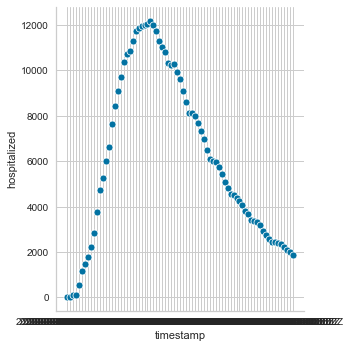

In [5]:
hospital.tail(5)
sns.relplot(x = 'timestamp', y = 'hospitalized', data = hospital)

In [6]:
age.head()
age['timestamp'] = pd.to_datetime(age['timestamp'])
#age['timestamp'] = age['timestamp'].dt.strftime("%m/%d/%y")
age.index = age['timestamp'] 
age.drop('timestamp', inplace = True, axis = 1)

In [7]:
age_bydate = age.groupby('type').resample('D').sum()
age_bydate.reset_index(inplace = True)
age_bydate['timestamp'] = age_bydate['timestamp'].dt.strftime("%m/%d/%y")

In [10]:
age_bydate.sample(10)

,type,timestamp,ages_0_17,ages_18_44,ages_45_64,ages_65_74,ages_75_older,unknown,total
130,deaths-no-underlying,04/14/20,0,25,59,26,27,0,137
244,deaths-probable,05/13/20,3,125,935,930,2371,1,4365
335,ever-hospitalized,04/29/20,282,5917,14447,9480,11520,2,41648
281,deaths-underlying,04/29/20,6,401,2363,2255,4140,0,9165
267,deaths-underlying,04/15/20,3,263,1447,1369,2466,0,5548
25,cases,04/16/20,2395,45648,44460,15490,13892,263,122148
48,cases,05/09/20,4459,65645,65546,22260,20504,352,178766
321,ever-hospitalized,04/15/20,205,4636,11198,6957,7905,2,30903
218,deaths-probable,04/17/20,0,72,522,560,1244,0,2398
256,deaths-underlying,04/04/20,3,165,760,746,1145,0,2819


<function matplotlib.pyplot.show>

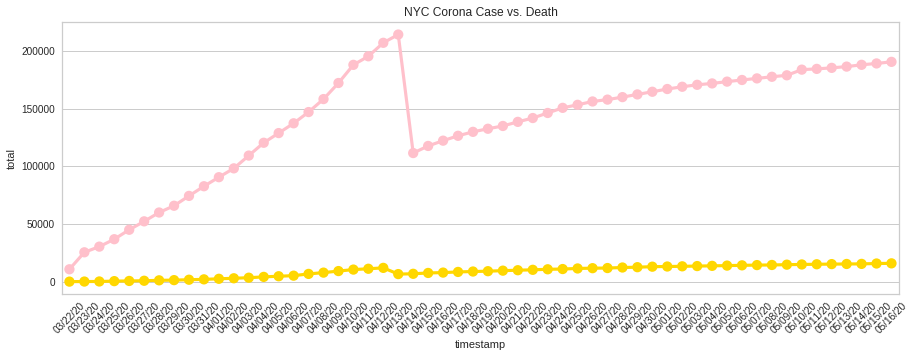

In [0]:
# NOT SURE WHY THE DROP HAPPENS - AS FAR AS I CAN SEE THERE ARE ONLY 1 REPORT PER DATE FROM ARPIL. PROBABLY THEY REPORTED TWICE, SO DOES NOT MAKE SENSE TO SUM. 
plt.figure(figsize=(15, 5))
sns.pointplot(x = 'timestamp', y = 'total' , data = age_bydate[age_bydate['type']=='cases'], color='pink')
sns.pointplot(x = 'timestamp', y = 'total' , data = age_bydate[age_bydate['type']=='deaths'], color='gold')
plt.xticks(rotation = 45)
plt.title('NYC Corona Case vs. Death')
plt.show

### CASE BY ZIP CODE


* Count of confirmed cases
* Rate of confirmed cases per 100,000 people by ZCTA
* Population denominators for ZCTAs derived from intercensal estimates by the Bureau of Epidemiology Services (see “Rates per 100,000 people” for more details)
* Count of confirmed deaths
* Percentage of people ever tested for COVID-19 who tested positive
* Rate of confirmed deaths per 100,000 people by ZCTA


In [0]:
case_by_zip.head()

,MODIFIED_ZCTA,NEIGHBORHOOD_NAME,BOROUGH_GROUP,COVID_CASE_COUNT,COVID_CASE_RATE,POP_DENOMINATOR,COVID_DEATH_COUNT,COVID_DEATH_RATE,PERCENT_POSITIVE
0,10001,Chelsea - Clinton,Manhattan,358,1519.33,23563.03,21,89.12,17.77
1,10002,Union Square - Lower East Side,Manhattan,1027,1338.02,76755.41,143,186.31,24.53
2,10003,Union Square - Lower East Side,Manhattan,445,827.11,53801.62,32,59.48,14.64
3,10004,Lower Manhattan,Manhattan,31,849.17,3650.61,1,27.39,15.20
4,10005,Lower Manhattan,Manhattan,61,726.53,8396.11,2,23.82,12.79


In [0]:
case_zip_group_sum = case_by_zip.groupby('BOROUGH_GROUP').sum().reset_index().drop(['MODIFIED_ZCTA','COVID_CASE_RATE','COVID_DEATH_RATE','PERCENT_POSITIVE'], axis = 1)
case_zip_group_mean = case_by_zip.groupby('BOROUGH_GROUP').mean().reset_index().drop(['BOROUGH_GROUP','MODIFIED_ZCTA','COVID_CASE_COUNT','POP_DENOMINATOR','COVID_DEATH_COUNT'], axis = 1)

#### Total Cases so far - need to confirm current counts
#### Need to calculate current COVID CASE RATE
#### Need to calculate future percent positive



In [0]:
case_zip_group = pd.concat([case_zip_group_sum, case_zip_group_mean], axis=1).reindex(case_zip_group_sum.index)
case_zip_group

,BOROUGH_GROUP,COVID_CASE_COUNT,POP_DENOMINATOR,COVID_DEATH_COUNT,COVID_CASE_RATE,COVID_DEATH_RATE,PERCENT_POSITIVE
0,Bronx,44005,1434692.65,3528,3085.314400,238.993600,31.191600
1,Brooklyn,52645,2582829.99,5057,2006.953243,200.613784,26.658378
2,Manhattan,23747,1611943.49,2246,1381.910455,124.227273,18.976136
3,Queens,59785,2288709.82,5031,2536.066780,199.473898,30.166271
4,Staten Island,13266,476179.01,817,2802.653333,162.840000,28.836667


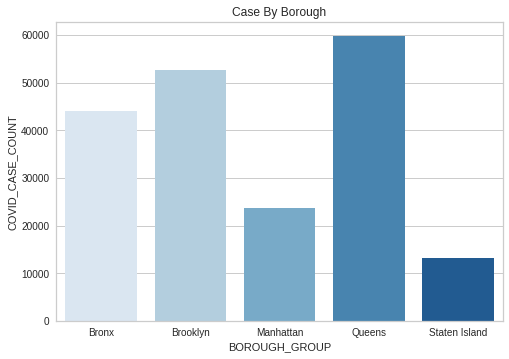

In [0]:
sns.barplot(x = 'BOROUGH_GROUP', y = 'COVID_CASE_COUNT', data = case_by_zip.groupby('BOROUGH_GROUP').sum().reset_index(), palette = 'Blues')
plt.title('Case By Borough')
plt.show()

This file contains counts and rates of confirmed cases, hospitalizations, and deaths, by NYC borough of residence. Rates are:

Cumulative since the start of the outbreak
Per 100,000 people by borough of residence
Note that sum of counts in this file may not match values in Citywide tables because of records with missing geographic information. This file does not currently contain information on probable deaths.

In [0]:
case_by_boro.tail(5)

,DATE_OF_INTEREST,BK_CASE_COUNT,BK_HOSPITALIZED_COUNT,BK_DEATH_COUNT,BX_CASE_COUNT,BX_HOSPITALIZED_COUNT,BX_DEATH_COUNT,MN_CASE_COUNT,MN_HOSPITALIZED_COUNT,MN_DEATH_COUNT,QN_CASE_COUNT,QN_HOSPITALIZED_COUNT,QN_DEATH_COUNT,SI_CASE_COUNT,SI_HOSPITALIZED_COUNT,SI_DEATH_COUNT
86,05/25/2020,153,18,6,89,20,4,66,9,9,106,16,6,24,0,2
87,05/26/2020,200,18,7,179,31,7,103,8,3,169,22,5,33,2,1
88,05/27/2020,90,10,2,80,16,3,55,3,1,83,11,6,16,0,0
89,05/28/2020,33,0,3,20,4,1,22,0,1,29,1,2,4,0,1
90,05/29/2020,3,0,0,2,0,0,1,0,0,0,0,0,0,0,0


# CONSTRAINTS

SOURCE: Marc Lipsitch, Harvard epidemiologist.

Adults hospitalized
Assumes hospitalization rate of 19% for those under 65 and 28.5% for those 65+.

Adults needing I.C.U. care
Assumes 19% I.C.U. rate for those hospitalized under 65 and 28.5% for those 65+.

**CONSTAINT 1: Patients**

In [0]:
#VOX.com article as of 3/27
#There are about 4700 covid-related hospitalization 
#850 ICU hospitalization 

In [0]:

MN_data = case_by_boro[['DATE_OF_INTEREST','MN_CASE_COUNT','MN_HOSPITALIZED_COUNT','MN_DEATH_COUNT']]

In [0]:
MN_data.head(5)

,DATE_OF_INTEREST,MN_CASE_COUNT,MN_HOSPITALIZED_COUNT,MN_DEATH_COUNT
0,02/29/2020,1,2,0
1,03/01/2020,0,0,0
2,03/02/2020,0,4,0
3,03/03/2020,0,4,0
4,03/04/2020,2,5,0


In [0]:
date_list = list()
in_hospital_list = list()

for i in range(len(MN_data)):
  if i <= 12: 
    in_hospital = sum(MN_data['MN_HOSPITALIZED_COUNT'][:i+1])+ - sum(MN_data['MN_DEATH_COUNT'][:i+1])
    date = MN_data['DATE_OF_INTEREST'][i]
    date_list.append(date)  
    in_hospital_list.append(in_hospital)
  else: 
    in_hospital = sum(MN_data['MN_HOSPITALIZED_COUNT'][:i+1]) - sum(MN_data['MN_DEATH_COUNT'][:i+1]) - MN_data['MN_HOSPITALIZED_COUNT'][i-13]
    date = MN_data['DATE_OF_INTEREST'][i]
    date_list.append(date)
    in_hospital_list.append(in_hospital)   
  
icu_hospital_list = list(np.around(np.array(in_hospital_list)*0.16))

MN_hospital_dict = {'Date': date_list, 'In_Hospital':in_hospital_list, 'In_ICU':icu_hospital_list}
MN_hospital = pd.DataFrame(MN_hospital_dict)

In [0]:
### VALIDATION AGAINST VOX TOTAL HOSPITALIZATION AND ICU
print(MN_hospital[MN_hospital['Date']=='03/27/2020'])
print(round(1545/4700*100,2)) # MAKES SENSE (32.87%)
print(round(294/850*100,2)) # MAKES SENSE (34.59%)

          Date  In_Hospital  In_ICU
27  03/27/2020         1545   247.0
32.87
34.59


In [0]:
MN_hospital.head(5)

,Date,In_Hospital,In_ICU
0,02/29/2020,2,0.0
1,03/01/2020,2,0.0
2,03/02/2020,6,1.0
3,03/03/2020,10,2.0
4,03/04/2020,15,2.0


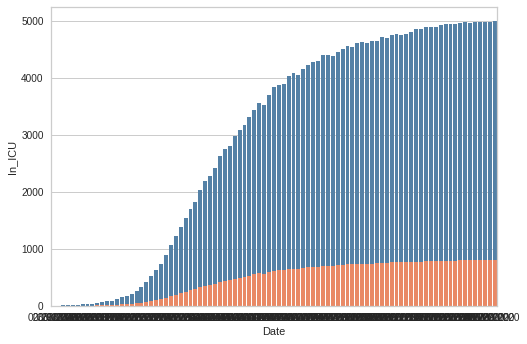

In [0]:
sns.barplot(x = 'Date', y = 'In_Hospital', data = MN_hospital, color = 'steelblue')
sns.barplot(x = 'Date', y = 'In_ICU', data = MN_hospital, color = 'coral')
plt.show()

**CONSTAINT 2: BEDS AVAILABLE**

https://docs.google.com/spreadsheets/d/1xAyBFTrlxSsTKQS7IDyr_Ah4JLBYj6_HX6ijKdm4fAY/edit#gid=0
-- ABOUT 50% of the total beds/ICU beds available are in NYC
* TOTAL BEDS IN MANHATTHAN 14,834	
* COVID OCCUPIED BEDS: 4969
* TOTAL ICU 1,427
* COVID OCCUPIED ICU: 795

In [0]:
beds[beds['locality']=='nyc'].head()

,timestamp,locality,total,total_available,icu,icu_available
1,2020-03-26T04:00:00Z,nyc,20394,3557,2011,307
3,2020-03-30T04:00:00Z,nyc,20898,3240,2449,392
5,2020-04-01T04:00:00Z,nyc,21167,3112,2565,352
7,2020-04-02T04:00:00Z,nyc,22910,3975,3082,370
9,2020-04-03T04:00:00Z,nyc,23957,5354,3256,419


**CONSTAINT 3: DOCTORS**
* NYC DOCTORS: 19,146
* NY State: 73,299
* Every 100k: 375.1 (2018)
* ASSUMED THAT THERE ARE 20% MORE DOCTORS IN MANHATTAN 
* Doctor: Patient Ratio: 1:24 (INTENSIVIST) - ASSUMED ABOUT 10% OF MEDICAL DOCTORS
* REGULAR DOCTOR: 1:10 (Assumption)

In [0]:
print(round(375.1*1.2*1611943.49/100000))
print('Perc of Doctors in MN: ' + str(round(7255.680037188/19146*100))+'%')

7256
Perc of Doctors in MN: 38%


## HOSPITAL ADMISSIONS RATE
* This file includes the rate of visits to NYC emergency departments (ED) per 100,000 people
* Rates of subsequent admissions to the hospital through the ED, for influenza-like illness or pneumonia, by date of visit for all ages and by age group (0-17, 18-44, 45-64, 65-74, 75+ years), since February 1, 2020 based on the Health Department’s syndromic surveillance system.

In [0]:
admission.mean()

Admit 0-17         0.751312
Admit 18-44        1.394286
Admit 45-64        5.230126
Admit 65-74        9.056205
Admit 75+         14.347013
Admit All ages     3.682550
Visit 0-17        13.288072
Visit 18-44       10.895500
Visit 45-64       15.730359
Visit 65-74       16.507482
Visit 75+         20.338363
Visit All ages    13.653367
dtype: float64

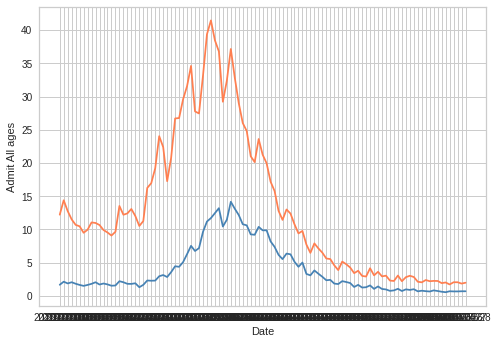

In [0]:
#admission.tail(5)
#Visit all ages: 1.88 * Mahattan Population/100000 * manhatthan proportion
# HOW TO GET AN IDEA OF HOW MANY PEOPLE ARE IN THE MANHATTHAN HOSPITAL. 



fig, ax = plt.subplots()
sns.lineplot(x='Date', y='Visit All ages', data=admission[admission['Date']>'2020-02-15'], color='coral')
sns.lineplot(x = 'Date', y = 'Admit All ages', data=admission[admission['Date']>'2020-02-15'], color = 'steelblue')
plt.show()


In [0]:
#int(1611943.49/100000)
round(23624/1611943.49*100000)	#1375.302273(on Average)

1466

## RETRIEVE NUMBER OF DOCTORS + NURSES
* http://www.op.nysed.gov/prof/nurse/nursecounts.htm#
* 

In [0]:
#prepare for python version 3x 
from __future__ import division, print_function

#import packages for web scraping/parsing

import requests #functions for interacting with web pages
from bs4 import BeautifulSoup ### DOM html manipulation
from string import whitespace
from nltk.corpus import stopwords
import nltk
from nltk import word_tokenize
from collections import Counter
import os
import re  
import string
from textblob import TextBlob

In [0]:
title_list = list()
doc = list()
url_list = list()
most_common_list = list()
doc_list = list()

In [0]:
def covid_doc_spider(max_pages): 
    page = 0
    while page <= max_pages:
        title_temp = list()
        url = 'https://www.nychealthandhospitals.org/doctors/page/' + str(page) + '/?doctor=Emergency%20Medicine&address&submit&specialty=1&sort_by&condition=1'
        source_code = requests.get(url)
        plain_text = source_code.text
        soup = BeautifulSoup(plain_text)
        views_field = soup.findAll('div','office_ad_info_doct_detl')
        for link in views_field:
            links = link.findAll('p')
            for x in links:
                doc_list.append(x.text)
        print(page)
        page += 1

In [0]:
#covid_doc_spider(100)

In [0]:
number = [x[0] for x in enumerate(doc_list)]
address = [x[1] for x in enumerate(doc_list)]
zipcode = [x.split()[-4] for x in address]

In [0]:
dict = {'number': number, 'address':address, 'zipcode':zipcode}
doctor_list = pd.DataFrame(dict)

In [0]:
doctor_list.head()

,number,address,zipcode
0,0,NYC Health + Hospitals/Woodhull 760 Broadway B...,11206
1,1,NYC Health + Hospitals/Woodhull 760 Broadway B...,11206
2,2,NYC Health + Hospitals/Woodhull 760 Broadway B...,11206
3,3,NYC Health + Hospitals/Woodhull 760 Broadway B...,11206
4,4,NYC Health + Hospitals/Woodhull 760 Broadway B...,11206


In [0]:
doctor_list.groupby(zipcode).agg(count_by_zip = pd.NamedAgg("zipcode", "count"))

,count_by_zip
10016,129
10029,42
10037,62
10451,106
10461,80
10467,85
11203,90
11206,98
11235,73
11373,87


In [0]:
pd.read_csv('sample_data/doctor_list.csv')

,Unnamed: 0,number,address,zipcode
0,0,0,NYC Health + Hospitals/Woodhull 760 Broadway B...,11206
1,1,1,NYC Health + Hospitals/Woodhull 760 Broadway B...,11206
2,2,2,NYC Health + Hospitals/Woodhull 760 Broadway B...,11206
3,3,3,NYC Health + Hospitals/Woodhull 760 Broadway B...,11206
4,4,4,NYC Health + Hospitals/Woodhull 760 Broadway B...,11206
...,...,...,...,...
962,962,962,NYC Health + Hospitals/Bellevue 462 First Aven...,10016
963,963,963,NYC Health + Hospitals/Bellevue 462 First Aven...,10016
964,964,964,NYC Health + Hospitals/Bellevue 462 First Aven...,10016
965,965,965,NYC Health + Hospitals/Bellevue 462 First Aven...,10016


### FORECAST
#### In case we are doing forecast on covid19 cases
* https://www.youtube.com/watch?v=vW2LnlZR3sA - LOGISTIC
* https://www.youtube.com/watch?v=AnzKI9B6gII - PROPHET